/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0720 - val_loss: 0.0716
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0617 - val_loss: 0.0792
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0636 - val_loss: 0.0635
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0605 - val_loss: 0.0662
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0545 - val_loss: 0.0613
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0596 - val_loss: 0.0662
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0514 - val_loss: 0.0555
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0487 - val_loss: 0.0543
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0479 - val_loss: 0.0572
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0449 - val_loss: 0.0479
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0492 - val_loss: 0.0522
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0

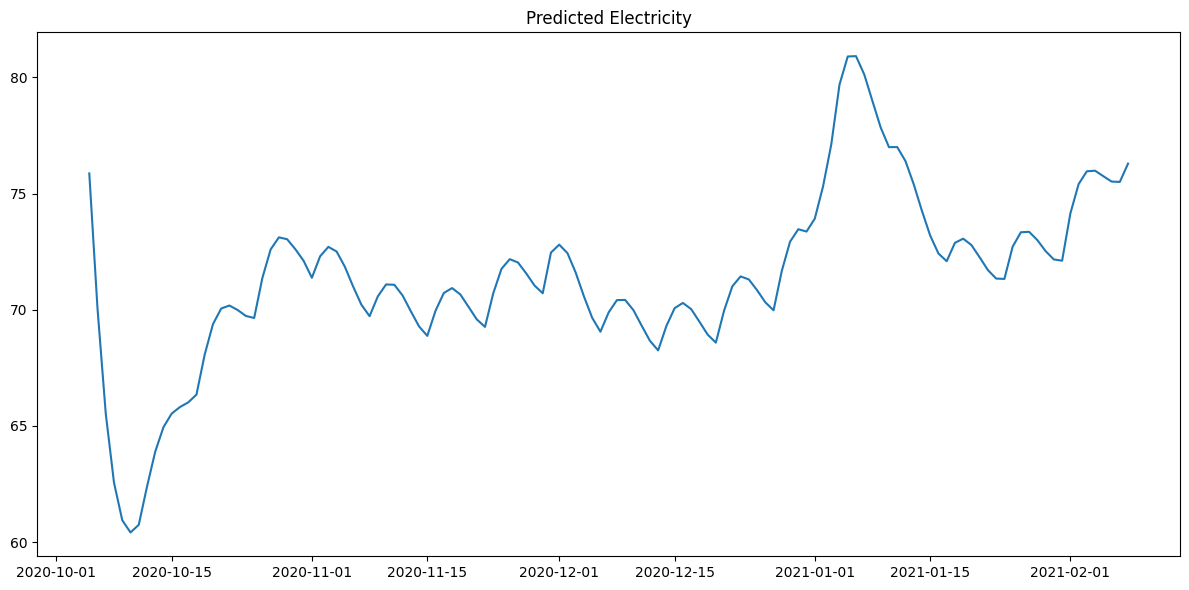

In [2]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras import models
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Sequential = models.Sequential
LSTM = layers.LSTM
Dense = layers.Dense
Dropout = layers.Dropout

# Load the dataset
data = pd.read_csv('dataset.csv', parse_dates=['Date'], index_col='Date')

# Extract relevant features
data['Day'] = data.index.day
data['Month'] = data.index.month
data['DayOfWeek'] = data.index.dayofweek

# Normalize the consumption and temperature data
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
data[['Temperature', 'Holiday', 'Day', 'Month', 'DayOfWeek']] = scaler_features.fit_transform(data[['Temperature', 'Holiday', 'Day', 'Month', 'DayOfWeek']])
data['Consumption'] = scaler_target.fit_transform(data[['Consumption']])

# Prepare X (features) and y (target)
X = data[['Consumption', 'Temperature', 'Holiday', 'Day', 'Month', 'DayOfWeek']].values
y = data['Consumption'].values

# Create sequences of data for LSTM
sequence_length = 60
X_seq, y_seq = [], []

for i in range(sequence_length, len(X)):
    X_seq.append(X[i-sequence_length:i])
    y_seq.append(y[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

# Get the start and end dates from user input
start_date = input("Enter the start date (YYYY-MM-DD): ")
end_date = input("Enter the end date (YYYY-MM-DD): ")

# Create a date range for the prediction period
prediction_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a DataFrame for the prediction period
prediction_data = pd.DataFrame(index=prediction_dates, columns=['Consumption', 'Temperature', 'Holiday', 'Day', 'Month', 'DayOfWeek'])

# Fill the prediction DataFrame with relevant data
prediction_data['Day'] = prediction_data.index.day
prediction_data['Month'] = prediction_data.index.month
prediction_data['DayOfWeek'] = prediction_data.index.dayofweek
prediction_data['Holiday'] = 0  # Assuming no holidays in the prediction period
prediction_data['Temperature'] = 20  # Assuming a constant temperature of 20 degrees Celsius
prediction_data['Consumption'] = 0  # Placeholder value for consumption

# Scale the features in the prediction DataFrame
prediction_data[['Temperature', 'Holiday', 'Day', 'Month', 'DayOfWeek']] = scaler_features.transform(prediction_data[['Temperature', 'Holiday', 'Day', 'Month', 'DayOfWeek']])

# Create sequences for prediction
prediction_seq = []
last_sequence = X[-sequence_length:]  # Get the last sequence from the original data

for i in range(len(prediction_data)):
    # Update the last sequence with the new data point
    new_sequence = np.append(last_sequence[1:], [prediction_data.iloc[i][['Consumption', 'Temperature', 'Holiday', 'Day', 'Month', 'DayOfWeek']].values], axis=0)
    prediction_seq.append(new_sequence)
    last_sequence = new_sequence

prediction_seq = np.array(prediction_seq)

# Make predictions
predictions = model.predict(prediction_seq)

# Inverse transform the predictions
predictions_inverse = scaler_target.inverse_transform(predictions)

# Create a DataFrame for the predicted values
predicted_data = pd.DataFrame(index=prediction_dates, data=predictions_inverse, columns=['Predicted Consumption'])

# Print the predicted values
print(predicted_data)
plt.figure(figsize=(12, 6))
plt.plot(predicted_data.index, predicted_data['Predicted Consumption'], label='Predicted Consumption')

# Customize the plot
plt.title('Predicted Electricity')
# Use tight layout to ensure all elements fit in the figure
plt.tight_layout()

# Show the plot
plt.show()